# Stance Detection

In [1]:
import numpy as np
import sys

sys.path.insert(1,"../")
from new_util import DataLoader
from preprocess import Preprocess
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
import torch


In [2]:

dataloader = DataLoader()

head,stances,body = dataloader.dataset()
len(head) == len(stances) == len(body)

True

In [3]:
  

# i dont like this 
def encoder(stance):
    if stance == "agree":
        return 0
    elif stance == "disagree":
        return 1
    elif stance == "discuss":
        return 2
    elif stance == "unrelated":
        return 3
    else:
        print(stance)
        raise

def one_hot(stance):
    st_id = encoder(stance) # beter code
    zeros = np.zeros(4)
    zeros[st_id] = 1
    return zeros
   
labels = [list(one_hot(i)) for i in stances] 
target = [encoder(i) for i in stances]
#print(stances)

In [4]:
print(labels[0])
print(stances[0])

[0.0, 0.0, 0.0, 1.0]
unrelated


In [5]:
pre = Preprocess()   # Glove embedding   
pre.parse()  

In [6]:
# strip out commas and unimportant words

def representation(data):
    pre_data = []
    for i in tqdm(data):
        words = []
        
        sep = i.split(" ")
        for s in sep:
            try:
                
                emb = pre.embeddings_dict[s.lower().replace("'","").replace(",","").replace("$15/","")]
                words.append(emb)

            except KeyError:
                pass
                #head_words.append()
        if words != []:
            
            pre_data.append(np.array(words))
   
    #return [x for x in pre_data if x != []]
    return pre_data 

In [7]:
# test representation 
head_output = representation(head[2])
head_output1 = representation(head[1])
body_output = representation(body[2])

In [8]:
# check if the list have an empty list

val = 0
for i in head_output:
    
    try:
        i[0]
        pass
    except IndexError:
        
        val+=1
        
print(val)

0


In [9]:
# PADDING PADDING PADDING PADDINGPADDINGPADDING 

# find max len of head

def padding(input,type):
    
    head_max = 200 # fix this with the maximum
    body_max = 1000
    
    input = input.squeeze()
  
    
    if type == "head":
        
        fixed_pad = head_max  - input.shape[0]
        result = F.pad(input=input,pad=(0,0,0,fixed_pad), mode='constant', value=0)
    elif type == "body":
        
        fixed_pad = body_max  - input.shape[0]
        result = F.pad(input=input,pad=(0,0,0,fixed_pad), mode='constant', value=0)
    else:
        raise
        
    return result

In [10]:
# test padding and fixed padding
data = torch.tensor(head_output)
res = data   # fix this code
padding_test = padding(res,"head")

data1 = torch.tensor(head_output1)
#res1 = data1   # fix this code
pad = padding(data1,"head")
print(pad.shape)
"""
print(padding_test.shape)
print(padding_test1.shape)
print(data1.shape)
print(data.shape)

print(padding_body.shape)"""

torch.Size([200, 50])


'\nprint(padding_test.shape)\nprint(padding_test1.shape)\nprint(data1.shape)\nprint(data.shape)\n\nprint(padding_body.shape)'

In [11]:
#single head output
head_output = np.array(head_output).squeeze()

In [12]:
# positional encoding from https://robelkebede.github.io/2020/11/06/positional-encoding.html

def pos_enc(word_emb,pos):
    
    word_pos,word_emb = [],np.array([i for i in word_emb],dtype=np.float64)
    
    #print(word_emb.shape)
    
    for i in range(len(word_emb)):
        k = 2*i / len(word_emb)
        
        if i%2 == 0:
            word_pos.append(np.sin(pos/(100**k)))
        else:
            word_pos.append(np.cos(pos/(100**k)))
            
   
    return  word_emb +word_pos
    

x1 = np.array([pos_enc(val,i) for i,val in enumerate(head_output)])


In [360]:
%matplotlib inline

In [366]:

print(x1.shape)
print(head[0])

AttributeError: 'builtin_function_or_method' object has no attribute 'shape'

TypeError: Image data of dtype object cannot be converted to float

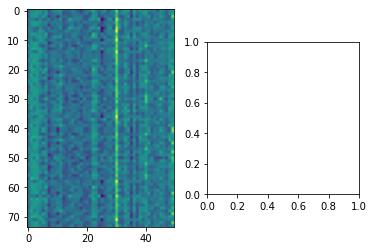

In [365]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(head_output.squeeze())
ax[1].imshow(x1)

ax[0].set_title("original")
ax[1].set_title("after positional encoding")

In [338]:
x1.shape

(74, 1, 50)

In [ ]:
        
# neural network 
# try to create your own self attention from scratch 

class NeuralNet(nn.Module):
    def __init__(self):
        
        super(NeuralNet,self).__init__()
        
        self.attention_head = MultiHeadAttention(in_features=50, head_num=1)
        
        self.Q_head = torch.rand(1,200,50) # 1 is the batch size
        self.K_head = torch.rand(1,200,50)
        self.V_head = torch.rand(1,200,50)
        
        self.attention_body = MultiHeadAttention(in_features=50, head_num=1)
        
        self.Q_body = torch.rand(1,1000,50) # 1 is the batch size
        self.K_body = torch.rand(1,1000,50)
        self.V_body = torch.rand(1,1000,50)
        
        # fully connected net 
                             #shape of the concatenated output
        self.fc1 = nn.Linear(60000, 30)   # (1200,50)
        self.fc2 = nn.Linear(30, 4)     # (1200,30)
        
        self.softmax = nn.Softmax(dim=0)
        
        
    def forward(self,head,body):
        # apply attention_head on head
        # apply attention_body on body
        
        head_attention  = self.attention_head(self.Q_head,self.K_head,self.V_head) + head
        body_attention  = self.attention_body(self.Q_body,self.K_body,self.K_body) + body
        
        
        merge = torch.cat((head_attention,body_attention),axis=1).squeeze().reshape(-1)
        print(merge.shape)
        output = self.fc1(merge)
        output = self.fc2(output)
        
        output = self.softmax(output)
        
        return output
        
        

In [ ]:
net = NeuralNet()
#print(net)

In [ ]:
# test the neural network

head = torch.tensor(head_output)
body = torch.tensor(body_output)
print(head.shape)
paded_head = padding(head,"head")
paded_body = padding(body,"body")
print(paded_body.shape)
print(paded_head.shape)

output = net(paded_head,paded_body)

In [ ]:
# Training 

lab = target[2]

creatrion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
loss = creatrion(output.view(1,-1),torch.tensor([lab]))

optimizer.zero_grad()   # zero the gradient buffers

loss.backward()
optimizer.step()    # Does the update
